# Project : Mace Head Station -  Windspeed Analysis 


This project analyzes wind patterns at Mace Head Meteorological Station in Ireland using historical data from 2003-2025.   
The analysis addresses six key research questions about wind behavior, turbine suitability, temporal trends, and energy potential.

Research questions:
1. What are the seasonal and daily wind patterns at Mace Head?
2. How suitable is the wind for turbine operation?
3. Are wind speeds changing over time?
4. What is the energy production potential?
5. History and Forecast of windspeed at Mace Head. 
6. Windspeed vs Temperature. 

## 1. Data loading & cleaning


### Import Python libraries/packages

In [59]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller  
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 1.1 Data collection    

Source : [Met Éireann  ](https://www.met.ie/climate/available-data/historical-data) - The Irish Meteorological Service  

In [60]:
# The dataset  was downloaded  from Met Éireann then named and saved in this repository
filename= "macehead_wind_data_to_date.csv"
directory="data/"
file_path = directory + filename

macehead_df = pd.read_csv(file_path, skiprows=17,)
# show
macehead_df

C:\Users\marou\AppData\Local\Temp\ipykernel_24740\2296933542.py:6: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  macehead_df = pd.read_csv(file_path, skiprows=17,)


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
0,13/08/2003 01:00,-1,,4,,4,,,,,,7,,7,
1,13/08/2003 02:00,-1,,4,,4,,,,,,7,,7,
2,13/08/2003 03:00,-1,,4,,4,,,,,,7,,7,
3,13/08/2003 04:00,-1,,4,,4,,,,,,7,,7,
4,13/08/2003 05:00,-1,,4,,4,,,,,,7,,7,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196243,31/12/2025 20:00,0,0.0,0,4.2,0,3.1,1.3,6.7,81,1025.5,2,5,2,90
196244,31/12/2025 21:00,0,0.0,0,4.0,0,2.9,1.1,6.6,80,1025.0,2,4,2,100
196245,31/12/2025 22:00,0,0.0,0,4.7,0,3.2,1.0,6.6,76,1024.3,2,3,2,130
196246,31/12/2025 23:00,0,0.0,0,6.7,0,4.8,2.1,7.1,72,1023.4,2,6,2,270


In [61]:
# read the first 14 rows to extract metadata and column descriptions, the rows include station info, location, and what each column represents
col_description = pd.read_csv(file_path, nrows=14, header=None, sep=";") 
# show columns description 
col_description

,0
0,"Station Name: MACE HEAD,,,,,,,,,,,,,,"
1,"Station Height: 21 M ,,,,,,,,,,,,,,"
2,"Latitude:53.326 ,Longitude: -9.901,,,,,,,,,,,,,"
3,",,,,,,,,,,,,,,"
4,",,,,,,,,,,,,,,"
5,"date: - Date and Time (utc),,,,,,,,,,,,,,"
6,"rain: - Precipitation Amount (mm)\t ,,,,,,,..."
7,"temp: - Air Temperature (C)\t,,,,,,,,,,,,,,"
8,"wetb: - Wet Bulb Temperature (C),,,,,,,,,,,,,,"
9,"dewpt: - Dew Point Temperature (C),,,,,,,,,,,,,,"


In [62]:
# convert date Dtype into datetime & force day-month-year interpretation
macehead_df['date'] = pd.to_datetime(macehead_df['date'],dayfirst=True, errors='coerce')

In [63]:
# dcheck ataset info
macehead_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196248 entries, 0 to 196247
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    196248 non-null  datetime64[ns]
 1   ind     196248 non-null  int64         
 2   rain    196248 non-null  object        
 3   ind.1   196248 non-null  int64         
 4   temp    196248 non-null  object        
 5   ind.2   196248 non-null  int64         
 6   wetb    196248 non-null  object        
 7   dewpt   196248 non-null  object        
 8   vappr   196248 non-null  object        
 9   rhum    196248 non-null  object        
 10  msl     196248 non-null  object        
 11  ind.3   196248 non-null  int64         
 12  wdsp    196248 non-null  object        
 13  ind.4   196248 non-null  int64         
 14  wddir   196248 non-null  object        
dtypes: datetime64[ns](1), int64(5), object(9)
memory usage: 22.5+ MB


In [64]:
# drop/remove columns that are not relevant to this analysis and store them into drop_col_list variable. 
drop_col_list = [ 'ind', 'rain', 'ind.1' , 'temp' , 'ind.2', 'wetb', 'dewpt', 'vappr' , 'rhum' , 'msl' , 'ind.3' , 'ind.4' , 'wddir']
macehead_df.drop(columns=drop_col_list, inplace=True)

# show the new dataframe with relevant columns
macehead_df.head((30))

,date,wdsp
0,2003-08-13 01:00:00,
1,2003-08-13 02:00:00,
2,2003-08-13 03:00:00,
3,2003-08-13 04:00:00,
4,2003-08-13 05:00:00,
5,2003-08-13 06:00:00,
6,2003-08-13 07:00:00,
7,2003-08-13 08:00:00,
8,2003-08-13 09:00:00,
9,2003-08-13 10:00:00,


In [65]:
# save the cleaned wind speed dataframe to a new CSV file, this new file can be used for comparison with the original messy dataset (multi indexes,additional columns)
macehead_df.to_csv('data/clean_macehead_windspeed.csv', index=True)

In [66]:
# reindexing : set the index of the dataframe to be a date
macehead_df.set_index('date',inplace=True)

# add df index as a column
macehead_df['date'] = macehead_df.index
# show
macehead_df['date']

date
2003-08-13 01:00:00   2003-08-13 01:00:00
2003-08-13 02:00:00   2003-08-13 02:00:00
2003-08-13 03:00:00   2003-08-13 03:00:00
2003-08-13 04:00:00   2003-08-13 04:00:00
2003-08-13 05:00:00   2003-08-13 05:00:00
                              ...        
2025-12-31 20:00:00   2025-12-31 20:00:00
2025-12-31 21:00:00   2025-12-31 21:00:00
2025-12-31 22:00:00   2025-12-31 22:00:00
2025-12-31 23:00:00   2025-12-31 23:00:00
2026-01-01 00:00:00   2026-01-01 00:00:00
Name: date, Length: 196248, dtype: datetime64[ns]

### 1.2 Data cleaning

In [67]:
# check for missing values from the entire df, the output doesnt retun any because the original missing values were filled with space. 
print(macehead_df.isna().sum())

wdsp    0
date    0
dtype: int64


In [68]:
# this method only replaces the cells with values that are exactly one space charcter. So this method catches only very simple missing values.
macehead_df.replace(' ', np.nan, inplace=True)

In [69]:
# check the rows with NaN values, to confirm if the space was indeed replaced by NaN values.
macehead_df.head(1400)[macehead_df.head(1400).isna().any(axis=1)]

# https://stackoverflow.com/questions/43424199/display-rows-with-one-or-more-nan-values-in-pandas-dataframe

,wdsp,date
date,,
2003-08-13 01:00:00,NaN,2003-08-13 01:00:00
2003-08-13 02:00:00,NaN,2003-08-13 02:00:00
2003-08-13 03:00:00,NaN,2003-08-13 03:00:00
2003-08-13 04:00:00,NaN,2003-08-13 04:00:00
2003-08-13 05:00:00,NaN,2003-08-13 05:00:00
...,...,...
2003-10-06 11:00:00,NaN,2003-10-06 11:00:00
2003-10-06 12:00:00,NaN,2003-10-06 12:00:00
2003-10-06 13:00:00,NaN,2003-10-06 13:00:00


In [70]:
# check missing values
print(macehead_df.isna().sum())

wdsp    1296
date       0
dtype: int64


In [71]:
# remove missing values
macehead_df.dropna(inplace=True)

In [72]:
# change windspeed Dtype into float instead of object
macehead_df['wdsp'] = macehead_df['wdsp'].astype('float64') 

## 2. Time series analysis

### 2.1 Hourly Windspeed per year since 2003 


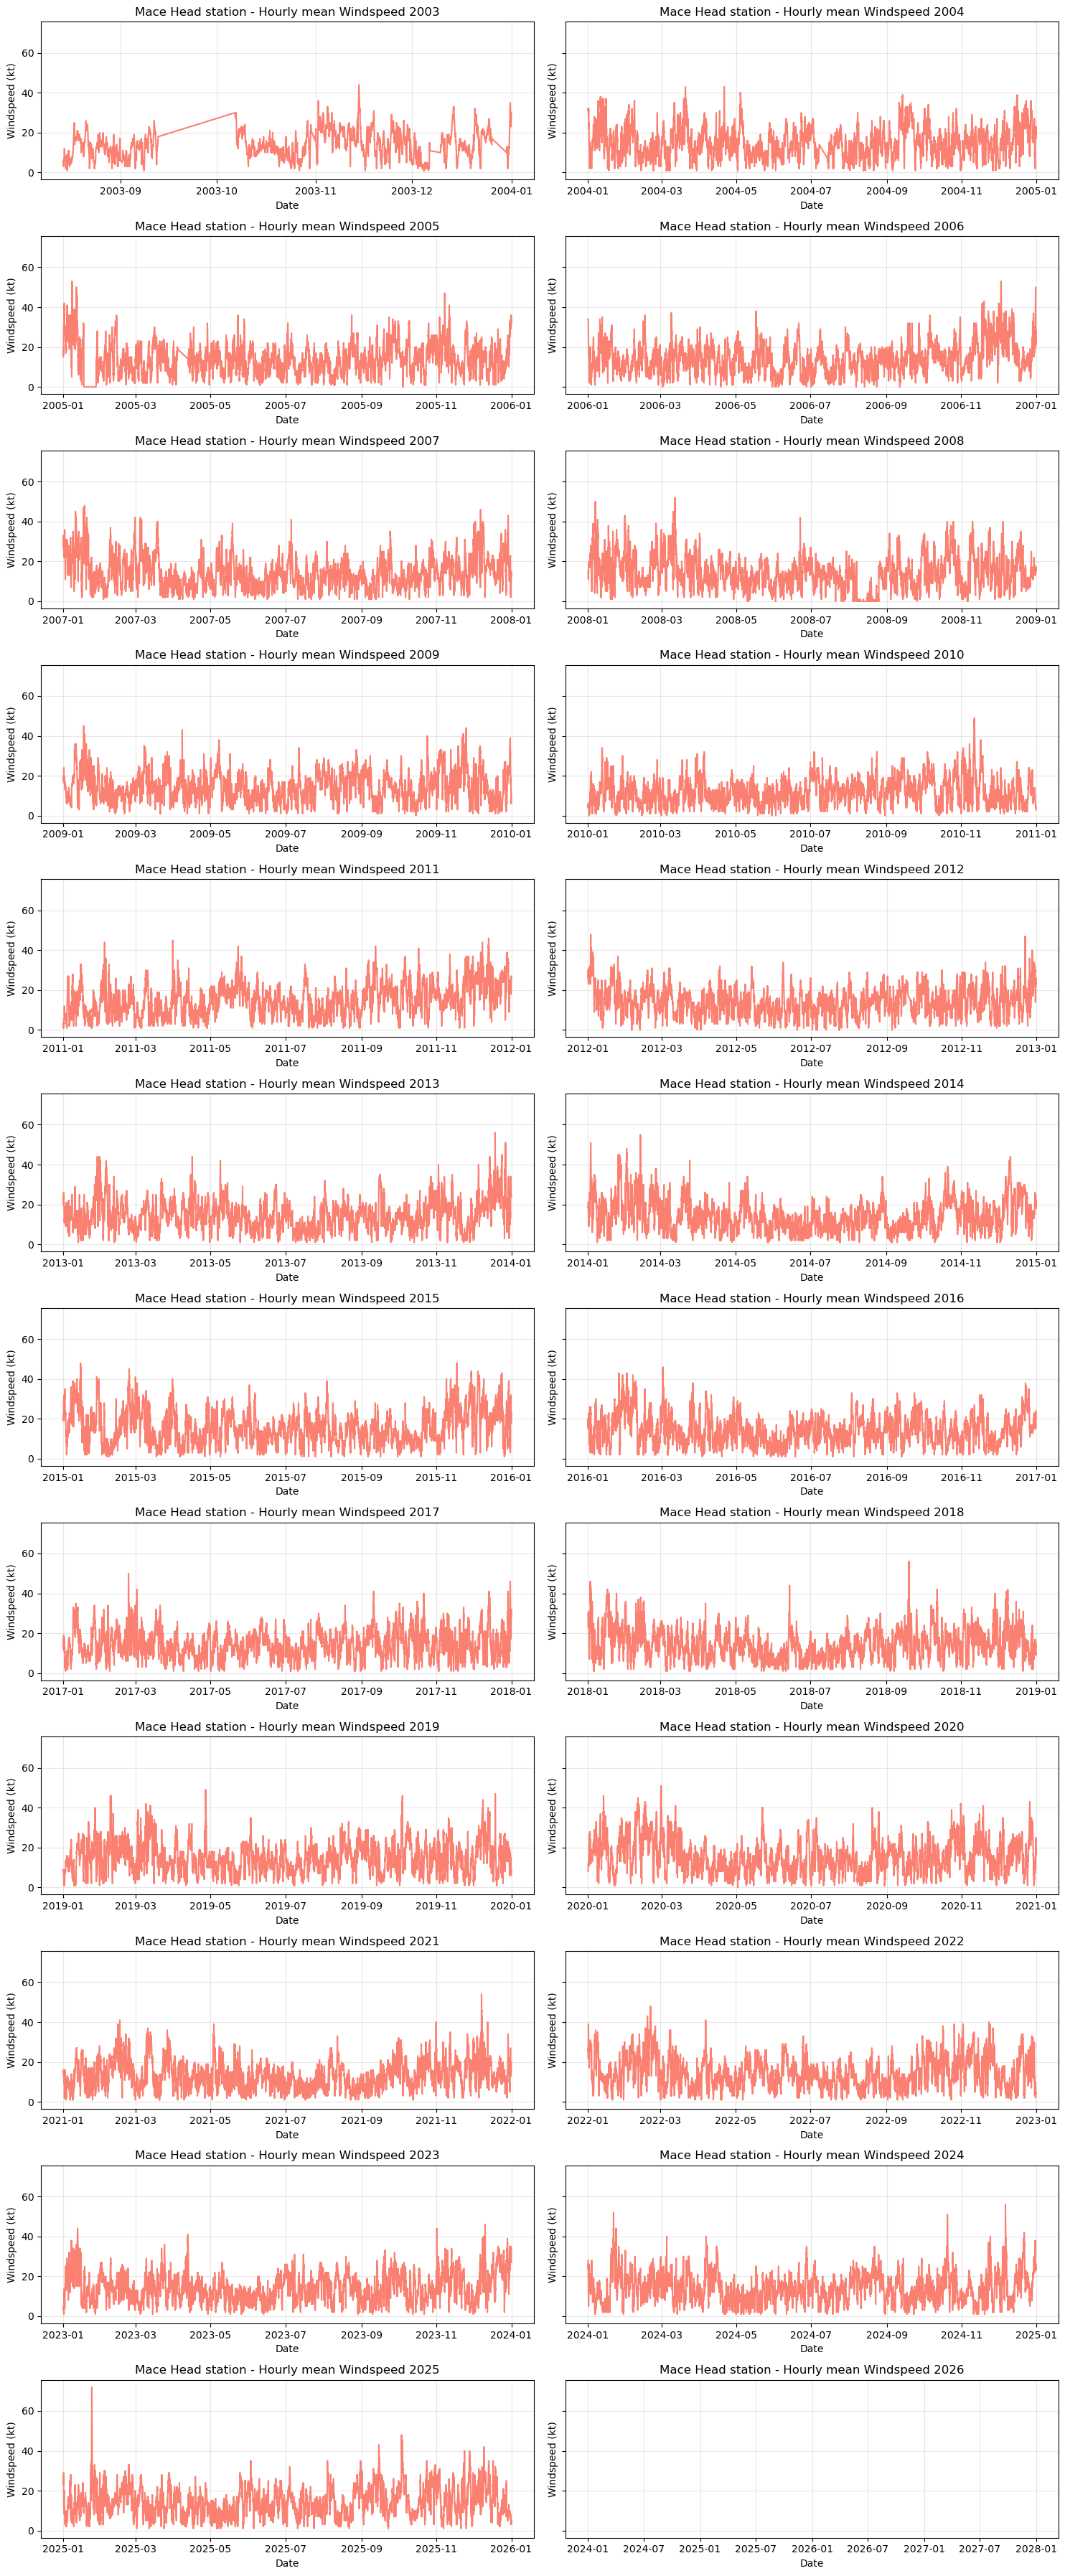

In [73]:
# add a new column for 'Years'
macehead_df["year"] = macehead_df["date"].dt.year

# select the year column from the dataframe, then returns all the values in that column
years = macehead_df["year"].unique()
years.sort()

# number of rows needed to fit n plots into cols columns
n = len(years)
cols = 2
rows = (n + cols - 1) // cols

cmap = plt.cm.viridis
norm = plt.Normalize(min(years), max(years))

# define grid size (2 columns)
fig, axes = plt.subplots(rows, cols, figsize=(15, rows*3), sharey=True)
axes = axes.flatten()  # flatten for easy indexing

# plot each year
for i, year in enumerate(years):
    data_year = macehead_df[macehead_df.index.year == year]
    axes[i].plot(data_year.index, data_year['wdsp'], color='salmon')
    axes[i].set_title(f'Mace Head station - Hourly mean Windspeed {year}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Windspeed (kt)')
    axes[i].grid(True, alpha=0.3)


# show
plt.tight_layout()
plt.show()

# method used : https://www.delftstack.com/howto/python/ceiling-division-python
# also, this solution was generated by AI (chat GPT) in response to the prompt : " How to plot a grid of yearly data using ceiling division in python  "



------------

Visual analysis of yearly wind patterns reveal a year to year variability, clear seasonal cycles are visible in every year, with higher winds in winter months and calmer periods during summer.  
Also, continuous time series provide a solid foundation for future analysis, as there are no extended periods of missing data that could false the results.

------------

### 2.2 Hourly mean windspeed overtime : 2003-2025  


Hourly mean wind speeds show how wind changes during the day.  


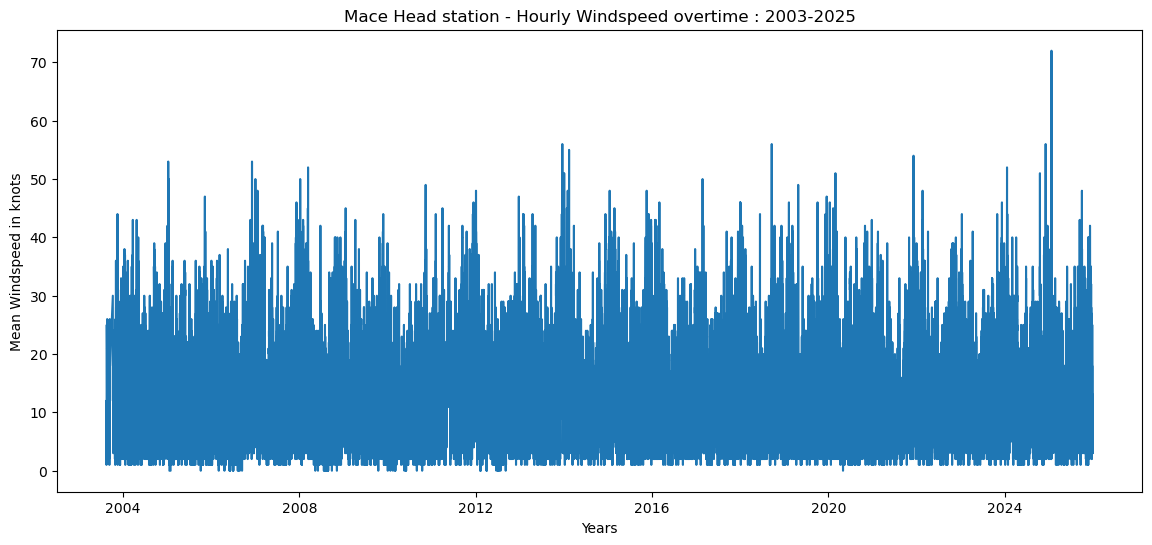

In [74]:
# plot windspeed overtime
plt.figure(figsize=(14,6))
sns.lineplot(data=macehead_df, x='date', y='wdsp')
plt.xlabel('Years')
plt.ylabel('Mean Windspeed in knots')
plt.title('Mace Head station - Hourly Windspeed overtime : 2003-2025')
plt.show()


### 2.3 Hourly wind speed in one year : 2025

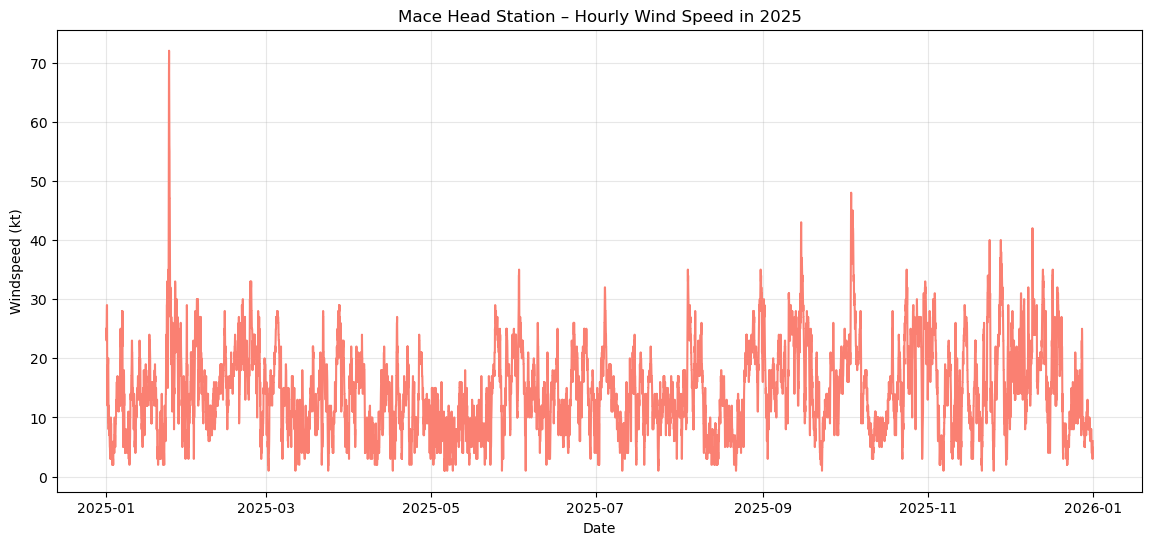

In [75]:
# select the year relevant to this plot
data_2025 = macehead_df[macehead_df.index.year == 2025]

# plot
plt.figure(figsize=(14,6))
plt.plot(data_2025.index, data_2025['wdsp'], color='salmon')
plt.title('Mace Head Station – Hourly Wind Speed in 2025')
plt.xlabel('Date')
plt.ylabel('Windspeed (kt)')
plt.grid(True, alpha=0.3)
plt.show()


### 2.4 Hourly wind speed on 24 Dec 2025, from 15:00 to 19:00 

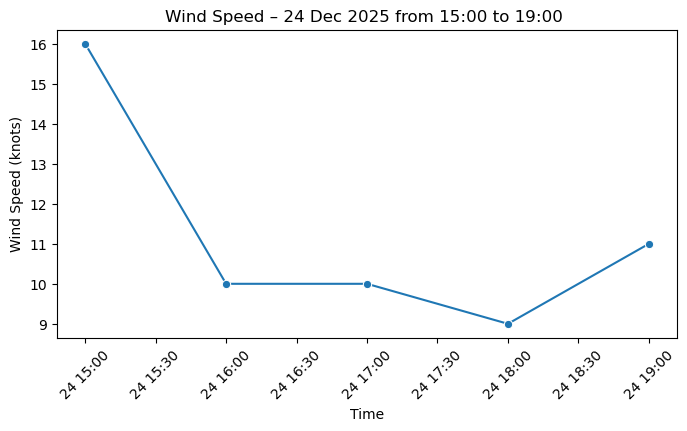

In [76]:
# loc 4 hour window
start_time = pd.to_datetime('2025-12-24 15:00:00')
end_time   = pd.to_datetime('2025-12-24 20:00:00')

# 4 hour slice
four_hours = macehead_df[(macehead_df['date'] >= start_time) & (macehead_df['date'] < end_time)]

# plot
plt.figure(figsize=(8,4))
sns.lineplot(data=four_hours, x='date', y='wdsp', marker='o')
plt.xlabel('Time')
plt.ylabel('Wind Speed (knots)')
plt.title('Wind Speed – 24 Dec 2025 from 15:00 to 19:00 ')
plt.xticks(rotation=45)
plt.show()

# https://www.geeksforgeeks.org/python/how-to-filter-dataframe-rows-based-on-the-date-in-pandas/


----------------------  

This plot focuses on a four hour window to show how wind speed changes over that period, highlighting short term trends and whether it is increasing or decreasing.

----------------------



### 2.5 Hourly Wind Speed Variation throughout one day at Mace Head

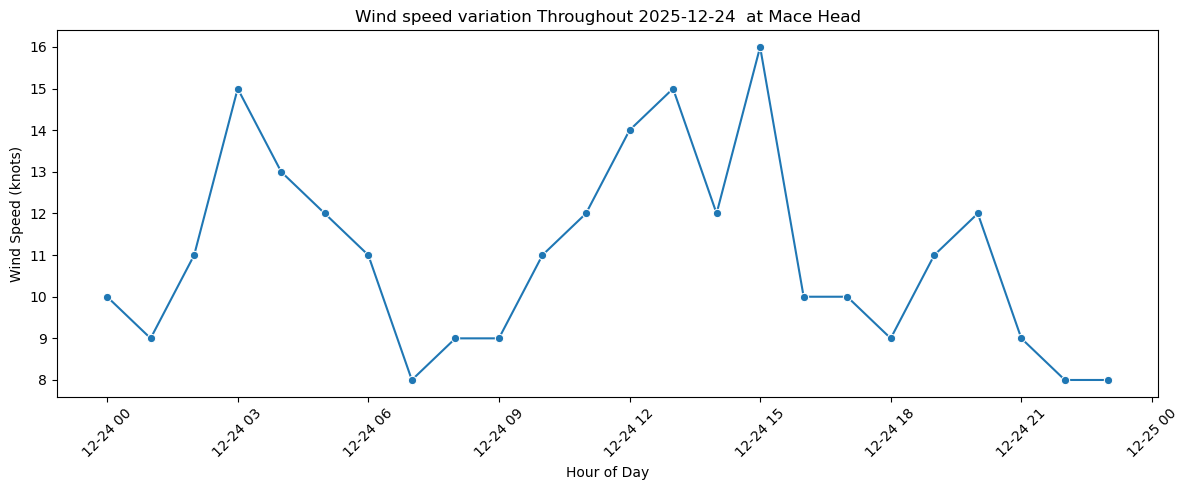

In [77]:
# choose a sample day
d = '2025-12-24 '

one_hour = macehead_df[(macehead_df['date'].dt.date == pd.to_datetime('2025-12-24').date())]

# extracting the date part of a datetime (.dt.date)
one_day = macehead_df[ macehead_df['date'].dt.date == pd.to_datetime(d).date()]

# plot hourly wind speed
plt.figure(figsize=(12,5))
sns.lineplot(data=one_day, x='date', y='wdsp', marker='o')

plt.xlabel('Hour of Day')
plt.ylabel('Wind Speed (knots)')
plt.title(f'Wind speed variation Throughout {d} at Mace Head')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# https://stackoverflow.com/questions/16176996/keep-only-date-part-when-using-pandas-to-datetime

-------------------   

This plot focuses on a single day to show how wind speed changes throughout that day.  

-----------------------

### 2.6  '24H' rolling windspeed over the years 2003-2025   


24H rolling windspeed is the average wind speed calculated continuously over the preceding 24 hours.  
Each hourly value is based on the wind speeds from the previous 24 hours, which creats a smoothed series that shows the general trend of wind conditions.  

Example:  
The rolling windspeed at 10 PM on 24 Dec 2025 is calculated from 10 PM on 23 Dec 2025 up to 10 PM on 24 Dec 2025.  
Then it moves forward hour by hour: the next hour (11 PM) takes the average from 11 PM the previous day to 11 PM today, and so on.  

In [78]:
# add a new column that stores the 24H wind speed 
macehead_df['rolling_24_windspeed'] = macehead_df['wdsp'].rolling(window=24).mean()

# this solution was generated by AI (chat GPT) in response to the prompt : " How to calculate a windspeed for rolling 24H in python using Pandas"

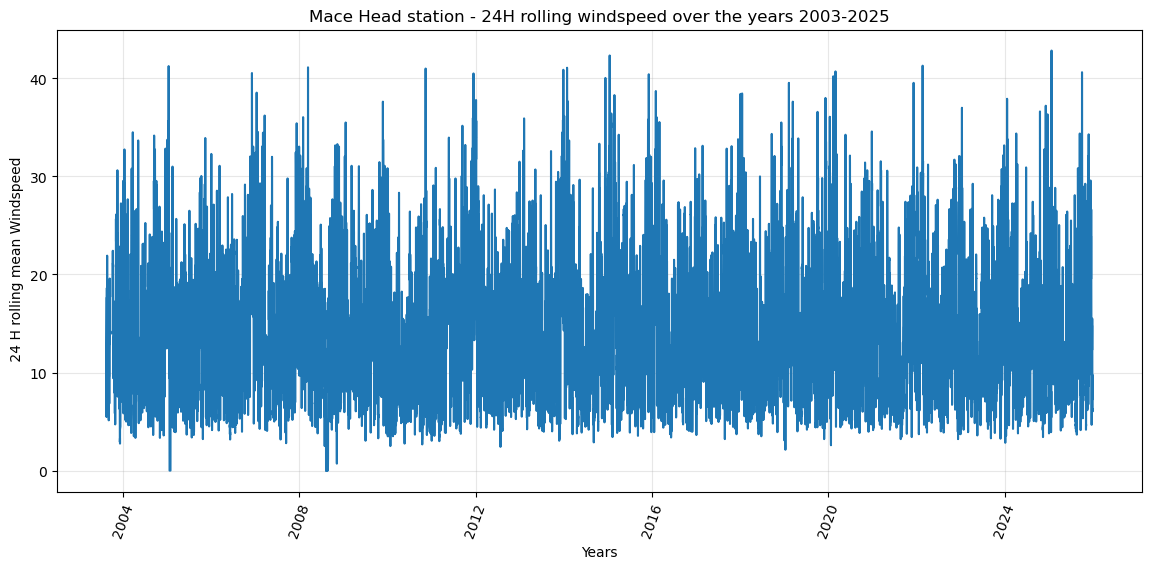

In [79]:
# plot
plt.figure(figsize=(14,6))
sns.lineplot(data=macehead_df, x='date', y='rolling_24_windspeed')
plt.xlabel('Years')
plt.xticks(rotation=70)
plt.ylabel(' 24 H rolling mean Windspeed')
plt.title('Mace Head station - 24H rolling windspeed over the years 2003-2025')
plt.grid(True, alpha=0.3)
plt.show()


### 2.7 '24H' rolling windspeed on 24/12/2025 at Mace Head


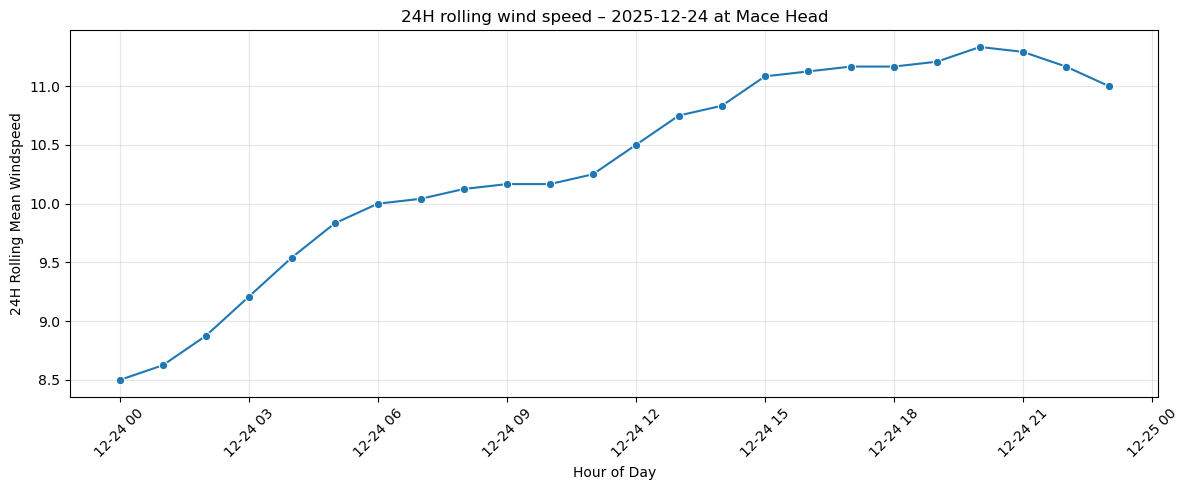

In [80]:
# choose a sample day
d = '2025-12-24'

# extract day after rolling is already computed
one_day = macehead_df[macehead_df['date'].dt.date == pd.to_datetime(d).date()]

# plot 24h rolling mean for one day
plt.figure(figsize=(12,5))
sns.lineplot(data=one_day, x='date', y='rolling_24_windspeed',marker='o')

plt.xlabel('Hour of Day')
plt.ylabel('24H Rolling Mean Windspeed')
plt.title(f'24H rolling wind speed – {d} at Mace Head')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


###  2.8 Daily mean windspeed overtime 2003-2025  


Daily mean wind speeds capture short term variability and periods of stronger winds influenced by weather.  

In [81]:
# resample hourly windspeed to daily mean temeprature. Each row now represents a calendar day 24H with its mean windspeed 
d_mean_windspeed = macehead_df['wdsp'].resample("D").mean()
# show daily mean windspeed. The result is a series indexed by dates.  
d_mean_windspeed

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling

date
2003-08-14     6.608696
2003-08-15     6.750000
2003-08-16     5.625000
2003-08-17    16.666667
2003-08-18    18.500000
                ...    
2025-12-28    10.500000
2025-12-29     8.291667
2025-12-30     9.208333
2025-12-31     6.041667
2026-01-01    13.000000
Freq: D, Name: wdsp, Length: 8177, dtype: float64

In [82]:
# seaborn plots columns not index values. Index resetting turns index into a normal column for plotting. 
daily_df = d_mean_windspeed.reset_index()
daily_df.columns = ['date', 'daily mean windspeed']
# show updated df 
daily_df

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html

,date,daily mean windspeed
0,2003-08-14,6.608696
1,2003-08-15,6.750000
2,2003-08-16,5.625000
3,2003-08-17,16.666667
4,2003-08-18,18.500000
...,...,...
8172,2025-12-28,10.500000
8173,2025-12-29,8.291667
8174,2025-12-30,9.208333
8175,2025-12-31,6.041667


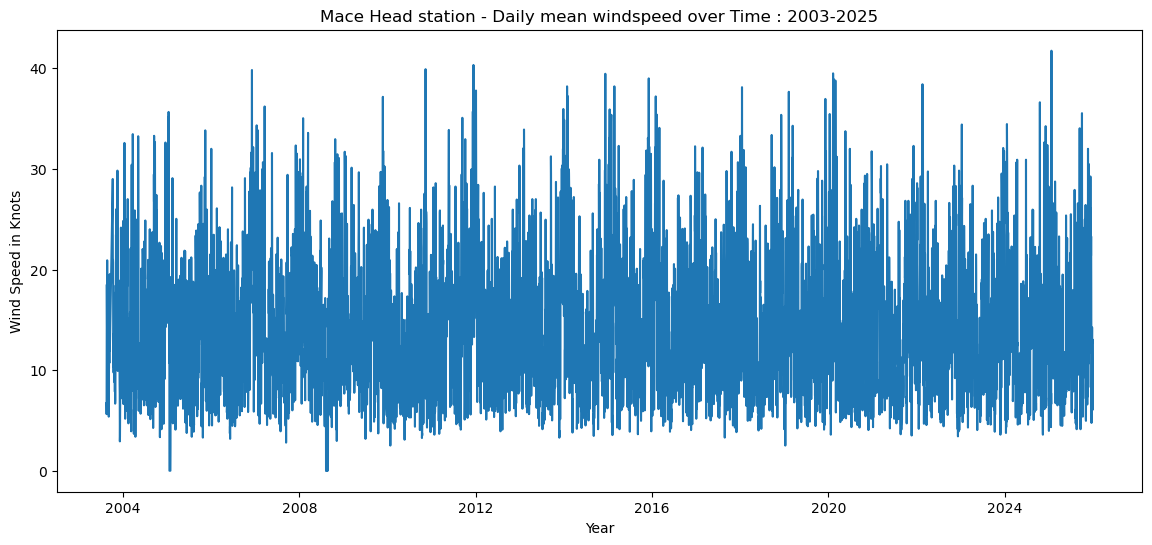

In [83]:
# plot
plt.figure(figsize=(14,6))
sns.lineplot(data=daily_df, x='date', y='daily mean windspeed')
plt.xlabel('Year')
plt.ylabel('Wind Speed in Knots')
plt.title('Mace Head station - Daily mean windspeed over Time : 2003-2025')
plt.show()

### 2.9 Daily Mean Windspeed for selected days

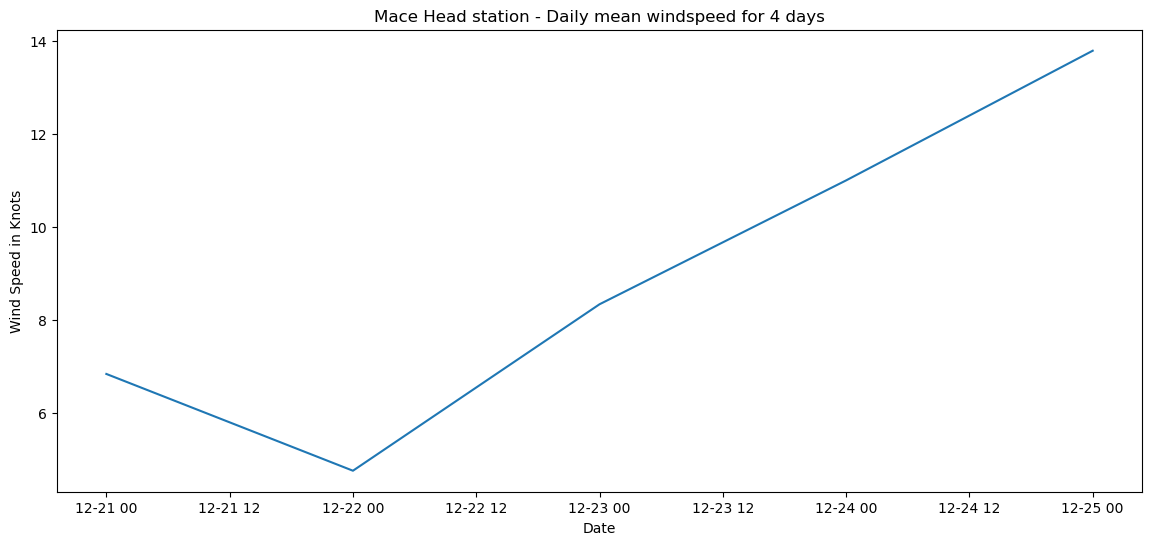

In [84]:
# select dates 
start_date = '2025-12-21'
end_date = '2025-12-25'

# filter the df for the selected period
one_week_df = daily_df[(daily_df['date'] >= start_date) & (daily_df['date'] <= end_date)]

# Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=one_week_df, x='date', y='daily mean windspeed')
plt.xlabel('Date')
plt.ylabel('Wind Speed in Knots')
plt.title('Mace Head station - Daily mean windspeed for 4 days')
plt.show()


# https://www.geeksforgeeks.org/python/how-to-filter-dataframe-rows-based-on-the-date-in-pandas/



### 2.10 Monthly mean windspeed over the years 2003-2025  


Monthly aggregation is used to identify seasonal patterns in wind behaviour.  

In [85]:
# resample hourly windspeed to monthly mean windspeed. Each row now represents a month with its mean windspeed 
m_mean_windspeed = macehead_df['wdsp'].resample("ME").mean()

# show monthly mean windspeed. I can see the result is a series indexed by dates.  
m_mean_windspeed

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling

date
2003-08-31    11.921114
2003-09-30    11.996310
2003-10-31    12.509632
2003-11-30    17.662500
2003-12-31    13.397482
                ...    
2025-09-30    17.184722
2025-10-31    17.491935
2025-11-30    15.705556
2025-12-31    16.459677
2026-01-31    13.000000
Freq: ME, Name: wdsp, Length: 270, dtype: float64

In [86]:
# to plot with Seaborn, the dates must be regular columns not index values. The reset index is here used to convert the index into a normal column for sns plotting purposes. 
monthly_df = m_mean_windspeed.reset_index()
monthly_df.columns = ['date', 'windspeed_monthly_mean']

# show updated df 
monthly_df

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html

,date,windspeed_monthly_mean
0,2003-08-31,11.921114
1,2003-09-30,11.996310
2,2003-10-31,12.509632
3,2003-11-30,17.662500
4,2003-12-31,13.397482
...,...,...
265,2025-09-30,17.184722
266,2025-10-31,17.491935
267,2025-11-30,15.705556
268,2025-12-31,16.459677


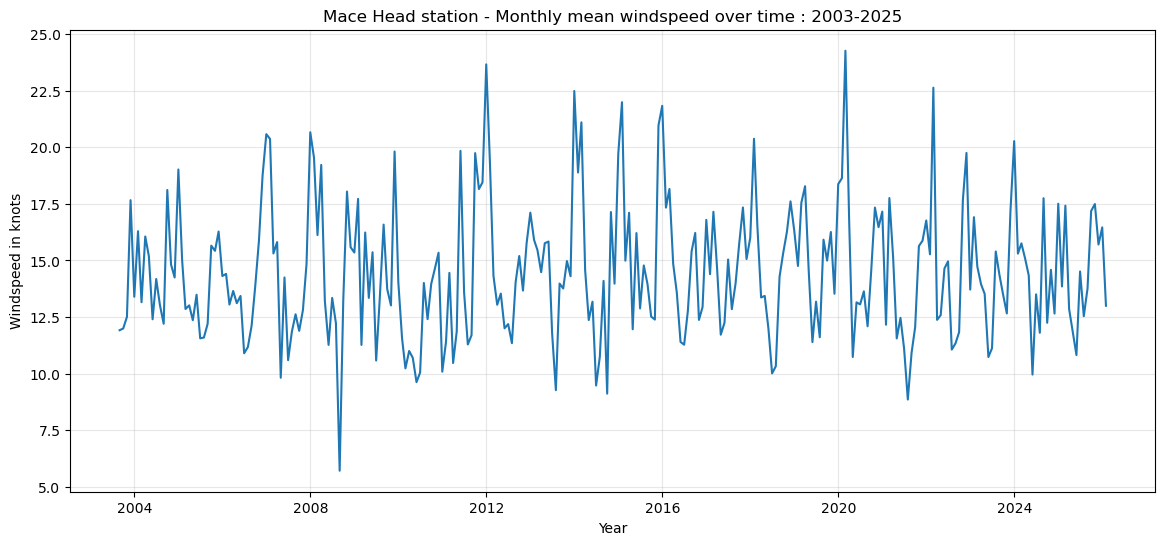

In [87]:
# plot
plt.figure(figsize=(14,6))
sns.lineplot(data= monthly_df, x='date', y='windspeed_monthly_mean')
plt.xlabel('Year')
plt.ylabel('Windspeed in knots')
plt.title('Mace Head station - Monthly mean windspeed over time : 2003-2025')
plt.grid(True, alpha=0.3)
plt.show()


### 2.11 Decembers Wind Speed analysis at Mace Head - yearly comparisons (2003-2025)

In [88]:
# show last few months to confirm that December 2025 data is included in dataset.  
print("Last 6 months:")
print(m_mean_windspeed.tail(6))

Last 6 months:
date
2025-08-31    13.763441
2025-09-30    17.184722
2025-10-31    17.491935
2025-11-30    15.705556
2025-12-31    16.459677
2026-01-31    13.000000
Freq: ME, Name: wdsp, dtype: float64


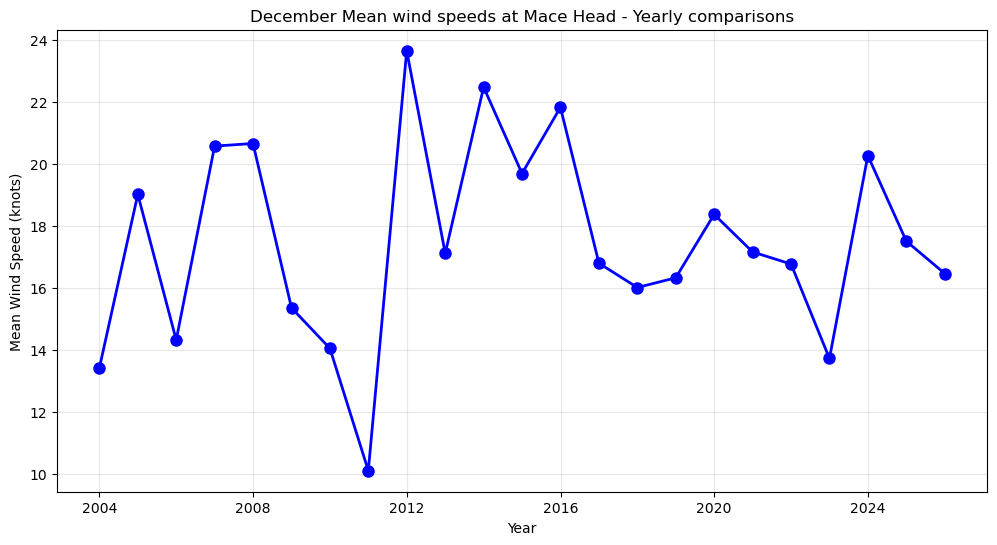

In [89]:
# extract each month of December's data since 2003 
december_data = m_mean_windspeed[m_mean_windspeed.index.month == 12]

# plot
plt.figure(figsize=(12,6))
plt.plot(december_data.index, december_data.values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Year')
plt.ylabel('Mean Wind Speed (knots)')
plt.title('December Mean wind speeds at Mace Head - Yearly comparisons')
plt.grid(True, alpha=0.3)

### 2.12 Wind speed trend 2004-2025 . 2004-2014 . 2015-2025

In [90]:
# check the latest year and see if 2025 is fully included
print(f"Data range: {m_mean_windspeed.index[0]} to {m_mean_windspeed.index[-1]}")
print(f"Years available: {m_mean_windspeed.index.year.unique()}")

Data range: 2003-08-31 00:00:00 to 2026-01-31 00:00:00
Years available: Index([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026],
      dtype='int32', name='date')


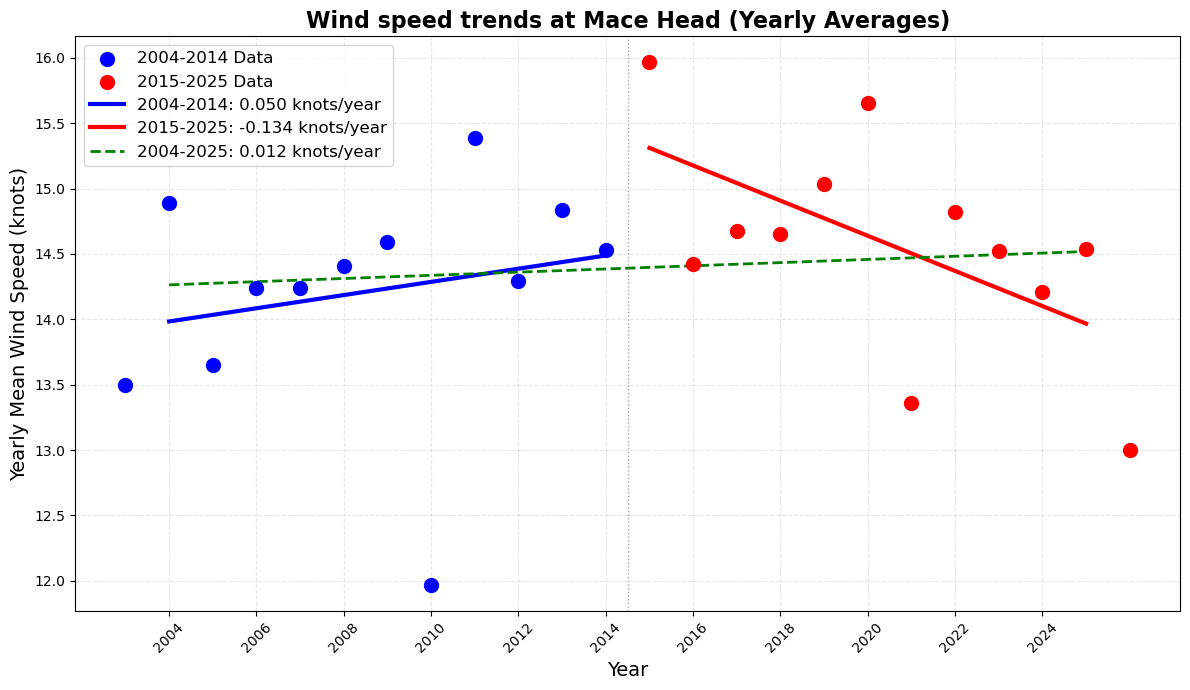

In [91]:
# convert monthly into yearly averages
yearly_wind = m_mean_windspeed.resample('YE').mean()

# extract year from the index
years = yearly_wind.index.year.values
wind_speeds = yearly_wind.values

# create dataframes for easy splitting
wind_df = pd.DataFrame({'year': years,'wind_speed': wind_speeds})

# first period 2004-2014
early_df = wind_df[wind_df['year'] <= 2014]
years_early = early_df['year'].values
wind_early = early_df['wind_speed'].values

# second period 2015-2025 
late_df = wind_df[wind_df['year'] >= 2015]
years_late = late_df['year'].values
wind_late = late_df['wind_speed'].values

# calculate for 2004-2014
slope_early, intercept_early, r_early, p_early, std_err_early = stats.linregress(years_early, wind_early)

# calculate for 2015-2025
slope_late, intercept_late, r_late, p_late, std_err_late = stats.linregress(years_late, wind_late)

# calculate for 2004-2025
slope_all, intercept_all, r_all, p_all, std_err_all = stats.linregress(years, wind_speeds)

# add figure
plt.figure(figsize=(12, 7))

# plot scatter points
plt.scatter(years_early, wind_early, color='blue', s=100, label='2004-2014 Data', zorder=5)
plt.scatter(years_late, wind_late, color='red', s=100, label='2015-2025 Data', zorder=5)

# plot trend lines

# 1st slice
x_fit_early = np.array([2004, 2014])
y_fit_early = intercept_early + slope_early * x_fit_early
plt.plot(x_fit_early, y_fit_early, 'b-', linewidth=3, label=f'2004-2014: {slope_early:.3f} knots/year')

# second slice
x_fit_late = np.array([2015, 2025])
y_fit_late = intercept_late + slope_late * x_fit_late
plt.plot(x_fit_late, y_fit_late, 'r-', linewidth=3, label=f'2015-2025: {slope_late:.3f} knots/year')

# linear regression since 2004
x_fit_all = np.array([2004, 2025])
y_fit_all = intercept_all + slope_all * x_fit_all
plt.plot(x_fit_all, y_fit_all, 'g--', linewidth=2, label=f'2004-2025: {slope_all:.3f} knots/year')

# add vertical line at transition for clear visual
plt.axvline(x=2014.5, color='gray', linestyle=':', linewidth=1, alpha=0.7)

# plot
plt.xlabel('Year', fontsize=14)
plt.ylabel('Yearly Mean Wind Speed (knots)', fontsize=14)
plt.title('Wind speed trends at Mace Head (Yearly Averages)', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='upper left', fontsize=12)
plt.xticks(range(2004, 2025, 2), rotation=45)
plt.tight_layout()


# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling
# https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#boolean-indexing
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
# https://github.com/Maroua-El-Imame/principles_of_data_analytics/blob/main/tasks.ipynb   >> 9: Fit a Simple Linear Regression


-------------------------------

**Results**:  

2004-2014: +0.050 knots/year (increasing)  

2015-2024: -0.134 knots/year (decreasing)  

2004-2024: +0.012 knots/year (slightly increasing overall)  

**Interpretation**:  

Before 2015: Winds were increasing by 0.05 knots/year  

After 2015: Winds reversed and are now decreasing by 0.134 knots/year  

Overall: The net effect is a very slight increase of 0.012 knots/year  

**Key insights** :  

Trend reversal around 2015 suggests changing climate patterns  
Recent decade shows significant decrease (-1.34 knots/decade)  
Long-term (2004-2024) still shows slight increase overall  
The 2015 transition probably aligns with broader climate shifts but further investigation will be needed for cause of reversal  

----------------------------------

### 3. Seasonal analysis  

A seasonal variable was created by mapping calendar months to meteorological seasons. This allows wind speed patterns to be analysed at a climatic scale rather than at individual time intervals.   

In this step I grouped months into seasons so I can compare wind behaviour in: Winter Spring Summer Autumn.   

This moves the analysis from calendar time into [climate structure](https://www.ncei.noaa.gov/news/meteorological-versus-astronomical-seasons#:~:text=You%20may%20have%20noticed%20that,dates%20in%20the%20Southern%20Hemisphere)

In [92]:
# ensure datetime
macehead_df.index = pd.to_datetime(macehead_df.index)

# extract month
macehead_df["month"] = macehead_df.index.month

# map months to seasons
def assign_season(month):
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Autumn"

macehead_df["season"] = macehead_df["month"].apply(assign_season)

# show months matching seasons 
macehead_df[["month", "season"]].head(1995)

,month,season
date,,
2003-08-14 01:00:00,8,Summer
2003-08-14 02:00:00,8,Summer
2003-08-14 03:00:00,8,Summer
2003-08-14 04:00:00,8,Summer
2003-08-14 05:00:00,8,Summer
...,...,...
2003-11-30 21:00:00,11,Autumn
2003-11-30 22:00:00,11,Autumn
2003-11-30 23:00:00,11,Autumn


In [93]:
# group df by season column 
seasonal_mean = macehead_df.groupby("season")["wdsp"].mean().reindex(["Winter","Spring","Summer","Autumn"])
seasonal_mean

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html

season
Winter    16.706912
Spring    13.479687
Summer    12.511936
Autumn    15.260713
Name: wdsp, dtype: float64

### 3.1  Wind speed by Season at Mace Head

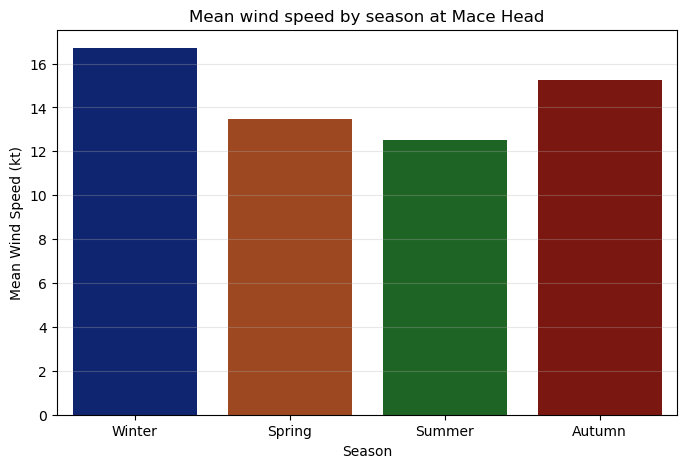

In [94]:
# barplot
plt.figure(figsize=(8,5))
sns.barplot(x=seasonal_mean.index, y=seasonal_mean.values, hue=seasonal_mean.index, palette="dark", legend=False)
plt.ylabel("Mean Wind Speed (kt)")
plt.xlabel("Season")
plt.title("Mean wind speed by season at Mace Head")
plt.grid(axis='y', alpha=0.3)
plt.show()

-----------------

Winter and Autumn show higher mean wind speeds, while summer exhibits lower values, providing insight into the seasonal variability of wind at Mace Head.  

----------------

### 3.2 Distribution of Daily mean wind speed by season at Mace Head  2003-2025

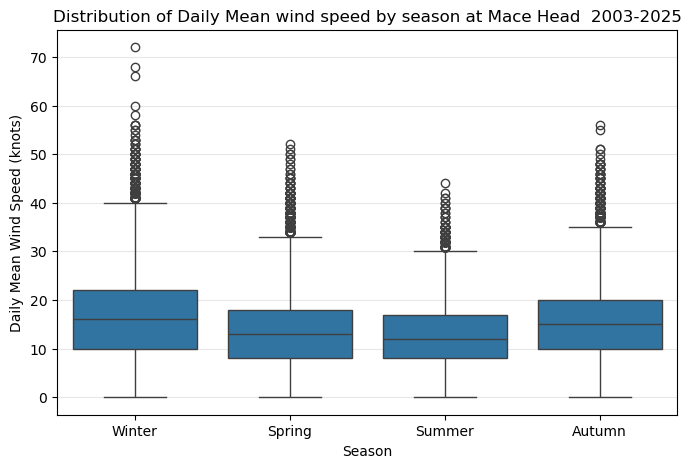

In [95]:
# boxplot
plt.figure(figsize=(8,5))
sns.boxplot(data=macehead_df, x='season', y='wdsp',order=['Winter', 'Spring', 'Summer', 'Autumn'])
plt.xlabel('Season')
plt.ylabel('Daily Mean Wind Speed (knots)')
plt.title('Distribution of Daily Mean wind speed by season at Mace Head  2003-2025')
plt.grid(axis='y', alpha=0.3)
plt.show()

-----------------

The boxplot shows clear seasonal variation in daily mean wind speeds at Mace Head.  
Winter exhibits the highest median wind speeds and the widest spread, indicating more variable winds.  
Summer has the lowest median and a narrower interquartile range, suggesting more stable winds.  

----------------



### 4. Wind Turbine assessment


#### Classify wind speeds according to Turbine thresholds

Wind speeds were classified according to typical turbine operating thresholds to assess the usability of wind resources at Mace Head.  

Turbines manufacturers provide a power curve, showing how much power a turbine produces at different wind speeds.  
This curve is important for selecting a site, estimating energy output, and monitoring performance. It highlights the cut-in (start), rated (maximum), and cut-out (stop) wind speeds, howver, actual turbine performance may differ from the ideal curve in real-world conditions.  

According to literature on wind turbine power curves, turbines only produce power between specific wind speed thresholds. Below the cut‑in speed (~3–4 m/s), turbines do not generate power. As wind increases, power increases up to the rated speed (~11–14 m/s), where maximum output occurs. Above the cut‑out speed (~23–25 m/s), turbines shut down for safety reasons.  
These thresholds are widely reported in power curve modeling studies.  


#### <u>*Conversion from knots to m/s*</u>
( We use the definition of a nautical mile (1852m) and the number of seconds in one hour (3600s)  )  
<br>

<br>

$$
1 \text{ knot} = \frac{1852}{3600} \text{ m/s} \approx 0.514444 \ldots \text{ m/s}
$$

$$
\text{m/s} = \text{knots} \times 0.51444
$$



#### <u>*Conversion from m/s to knots*</u> 
(Using the same previous definition)  
<br>


$$
1 \text{ m/s} = \frac{3600}{1852} \text{ knots} \approx 1.943844\ldots \text{ knots}
$$

$$
\text{knots} = \text{m/s} \times 1.94384
$$


In [96]:
# sample dataframe
data = {
    'Threshold': ['Cut-in', 'Rated', 'Cut-out'],
    'Wind Speed (m/s)': ['3-4', '11-14', '23-25'],
    'Description': [
        'Turbine starts generating power',
        'Turbine reaches maximum output',
        'Turbine shuts down for safety'
    ]
}

df = pd.DataFrame(data)

# function to convert m/s range to knots range
# https://docs.python.org/3/library/functions.html

def ms_to_knots(ms_range):
    low, high = map(float, ms_range.split('-'))
    low_knots = round(low * 1.94384)
    high_knots = round(high * 1.94384)
    return f"{low_knots}-{high_knots}"

# add the knots column 2nd (in position 1)
df.insert(1, 'Wind Speed (knots)', df['Wind Speed (m/s)'].apply(ms_to_knots))
# show
df

,Threshold,Wind Speed (knots),Wind Speed (m/s),Description
0,Cut-in,6-8,3-4,Turbine starts generating power
1,Rated,21-27,11-14,Turbine reaches maximum output
2,Cut-out,45-49,23-25,Turbine shuts down for safety


In [97]:
# function to assign threshold based on knots
def assign_threshold(ws):
    if ws < 6:
        return 'Off'
    elif 6 <= ws <= 8:
        return 'Start'
    elif 8 < ws < 21:
        return 'Low'
    elif 21 <= ws <= 27:
        return 'Max'
    elif 27 < ws < 45:
        return 'Max+'
    elif 45 <= ws <= 49:
        return 'Shutdown'
    else:
        return 'Extreme'

# apply to dataframe
macehead_df['Threshold'] = macehead_df['wdsp'].apply(assign_threshold)

# reset index
macehead_df = macehead_df.reset_index(drop=True)

# show df
macehead_df[['date', 'wdsp', 'Threshold']].head(100)

,date,wdsp,Threshold
0,2003-08-14 01:00:00,6.0,Start
1,2003-08-14 02:00:00,4.0,Off
2,2003-08-14 03:00:00,3.0,Off
3,2003-08-14 04:00:00,5.0,Off
4,2003-08-14 05:00:00,6.0,Start
...,...,...,...
95,2003-08-18 00:00:00,18.0,Low
96,2003-08-18 01:00:00,18.0,Low
97,2003-08-18 02:00:00,17.0,Low
98,2003-08-18 03:00:00,17.0,Low


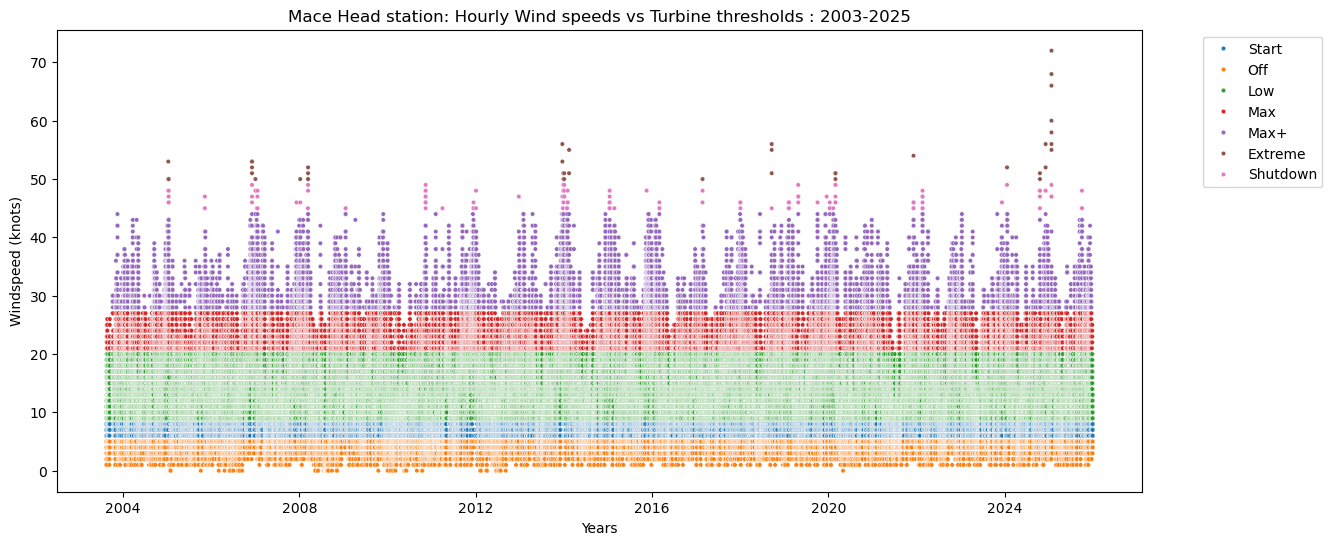

In [98]:
# plot treshold 
plt.figure(figsize=(14,6))
sns.scatterplot(data=macehead_df,x='date',y='wdsp',hue='Threshold',palette='tab10',s=10)
plt.xlabel('Years')
plt.ylabel('Windspeed (knots)')
plt.title('Mace Head station: Hourly Wind speeds vs Turbine thresholds : 2003-2025')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()

--------------------------

Wind speeds at Mace Head predominantly fall within turbine-operable ranges, with extreme shutdown events being rare and concentrated in winter storm seasons.  

-------------------

## 5. Forecasting & Energy estimation

### 5.1 Turbine operation analysis


In [99]:
# calculate percentage distribution of wind speed categories. '.value_counts(normalize=True)' gives proportions (0 to 1) of each category
# multiply by 100 converts to percentage

threshold_counts = macehead_df['Threshold'].value_counts(normalize=True) * 100

for status in ['Off', 'Start', 'Low', 'Max', 'Max+', 'Shutdown', 'Extreme']:
    if status in threshold_counts.index:
        print(f"  {status}: {threshold_counts[status]:.1f}%")


  Off: 10.7%
  Start: 12.8%
  Low: 56.4%
  Max: 14.3%
  Max+: 5.8%
  Shutdown: 0.1%
  Extreme: 0.0%


In [100]:
# calculate operational hours (excluding 'Off', 'Extreme','Shutdown')
operational_hours = threshold_counts[['Start', 'Low', 'Max', 'Max+']].sum()
print(f"\nTurbine would be operational {operational_hours:.1f}% of the time")


Turbine would be operational 89.2% of the time


### 5.2 ARIMA (Autoregressive Integrated Moving Average) Forecasting


##### *ADF Test - Stationarity Check*  


* Why We Test Stationarity  
Before forecasting with ARIMA, we need to ensure our wind data is "predictable" - meaning it has consistent patterns over time.  
The Augmented Dickey-Fuller (ADF) test checks if our data meets this requirement.  

* What is Stationarity?  
A stationary time series has three key properties:  

    Constant Mean - The average value doesn't trend up or down  
    Constant Variance - The ups and downs are similar throughout  
    Constant Autocorrelation - The relationship between wind speeds depends only on how many days apart they are, not when they occur. 

* The forecasting Process  
Check stationarity (ADF test on 2025 daily wind data)  
If non-stationary → ARIMA automatically applies differencing (d=1)  
Build model using past winds and forecast errors  
Forecast next 7 days  


* Differencing (how we remove trends)  
Today's wind - Yesterday's wind = Trend removed data  
This simple subtraction removes upward/downward trends, making data stationary.  

*   ARIMA(1,1,1) breaks down as:  
- p=1 (AR term): Today's wind = Yesterday's wind × coefficient + error  
- d=1 (Differencing): We model changes in wind (today - yesterday)  
- q=1 (MA term): Today's forecast includes yesterday's forecast error  

* Result Interpretation  
p-value < 0.05 = Data is stationary (Good for ARIMA)  
p-value ≥ 0.05 = Data has trends/seasonality (Needs differencing)  

* Model Selection  
Trend in data? → Use ARIMA (which includes differencing)  

Our case: We test 2025 daily wind speeds to ensure reliable 7 day forecasts.  

### 5.2.1 Initial ARIMA forecast using default parameters  

ADF Statistic: -9.8700, p-value: 0.0000
                               SARIMAX Results                                
Dep. Variable:                   wdsp   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1117.549
Date:                Mon, 12 Jan 2026   AIC                           2241.098
Time:                        01:56:10   BIC                           2252.790
Sample:                    01-01-2025   HQIC                          2245.745
                         - 12-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5581      0.040     13.978      0.000       0.480       0.636
ma.L1         -0.9853      0.011    -92.414      0.000      -1.006      -0.964
sigma2      

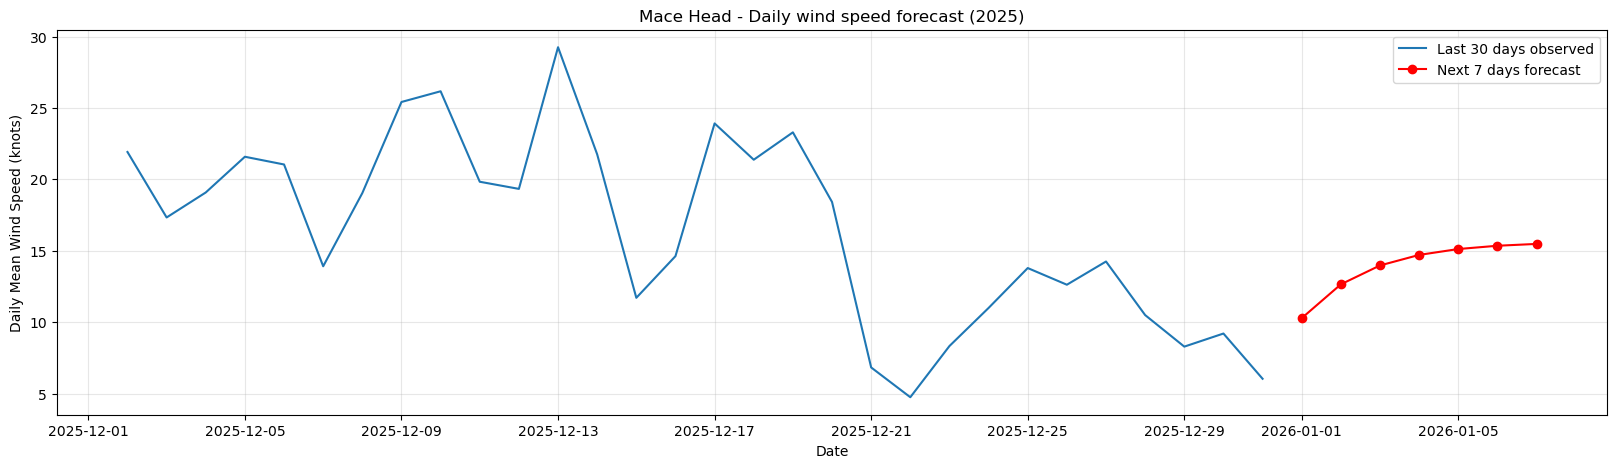

In [101]:
# load data for 2025 only
# ensure date is datetime and set as index
macehead_df['date'] = pd.to_datetime(macehead_df['date'])
macehead_df.set_index('date', inplace=True)
macehead_2025 = macehead_df['wdsp']['2025']

# resample to daily mean wind speed
daily_wind_2025 = macehead_2025.resample('D').mean()

# check stationarity
adf_result = adfuller(daily_wind_2025.dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}, p-value: {adf_result[1]:.4f}")
if adf_result[1] > 0.05:
    print("Series is non-stationary. ARIMA will difference it automatically with d=1.")

# model fit ARIMA
model = ARIMA(daily_wind_2025, order=(1,1,1))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

# make prediction : forecast next 7 days
forecast = model_fit.forecast(steps=7)

# plot last 30 days + forecast
plt.figure(figsize=(20,5))
plt.plot(daily_wind_2025[-30:], label='Last 30 days observed')
plt.plot(forecast.index, forecast, label='Next 7 days forecast', color='red', marker='o')
plt.xlabel('Date')
plt.ylabel('Daily Mean Wind Speed (knots)')
plt.title('Mace Head - Daily wind speed forecast (2025)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# https://towardsdatascience.com/time-series-forecasting-made-simple-part-4-1-understanding-stationarity-in-a-time-series/
# https://towardsdatascience.com/time-series-analysis-introduction-a-comparison-of-arma-arima-sarima-models-eea5cbf43c73/
# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/#:~:text=Shampoo%20Sales%20Data-,ARIMA%20with%20Python,-The%20statsmodels%20library
# https://otexts.com/fpp2/arima.html


### 5.2.2 Model Diagnostics - Can the default model be improved?

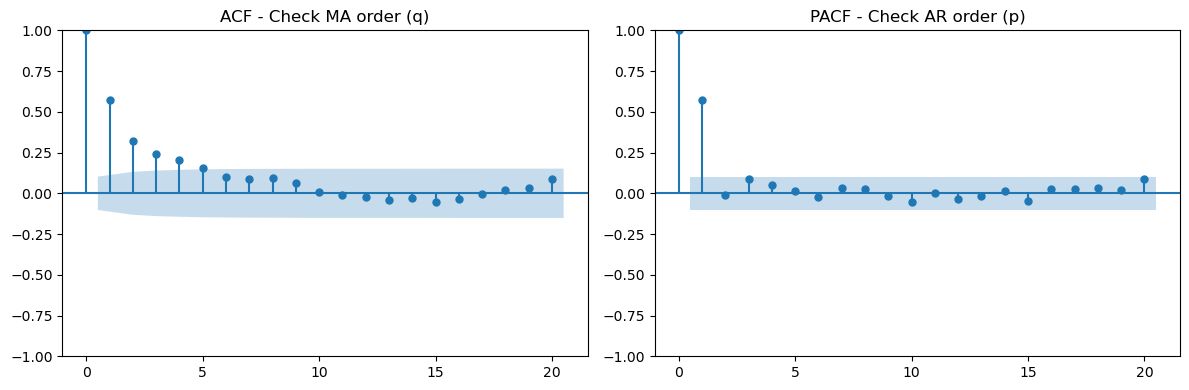

In [102]:
# plot ACF and PACF to validate if ARIMA (1,1,1) is correct
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(daily_wind_2025.dropna(), lags=20, ax=axes[0])
axes[0].set_title('ACF - Check MA order (q)')

plot_pacf(daily_wind_2025.dropna(), lags=20, ax=axes[1])
axes[1].set_title('PACF - Check AR order (p)')

plt.tight_layout()
plt.show()


# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html

### 5.2.3 Model diagnostics - Finding optimal parameters

In [103]:
# differencing - check if data needs differencing
result = adfuller(daily_wind_2025.dropna())
if result[1] > 0.05:  # p-value > 0.05 = non-stationary
    d = 1  # needs 1 differencing
else:
    d = 0  # already stationary

# 2. AUTOREGRESSIVE ORDER (p) - Look at PACF
# Count how many lags EXCEED the grey band in PACF plot
# If lags 1,2,3 are significant → p=3
# If only lag 1 is significant → p=1

# 3. MOVING AVERAGE ORDER (q) - Look at ACF  
# Count how many lags EXCEED the grey band in ACF plot
# If lags 1,2 are significant → q=2
# If only lag 1 is significant → q=1

# 4. VISUAL METHOD:
print("READING THE PLOTS:")
print("PACF significant at lags: [1,2] → p=2")
print("ACF significant at lags: [1] → q=1") 
print("ADF p-value > 0.05 → d=1")
print("Result: ARIMA(2,1,1)")

# Phttps:/pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html


# Code developed with AI assistance (DeepSeek) for parameter understanding. 
# code validation, and documentation verification against official library resources.
# Key references: Pandas time series, Statsmodels ARIMA, ACF/PACF documentation.  

READING THE PLOTS:
PACF significant at lags: [1,2] → p=2
ACF significant at lags: [1] → q=1
ADF p-value > 0.05 → d=1
Result: ARIMA(2,1,1)


### 5.2.4 ARIMA Model Comparison  

Yesterday only (1,1,1) vs Yesterday + 2 days ago (2,1,1) 

C:\Users\marou\AppData\Local\Temp\ipykernel_24740\2608646160.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(daily_wind_2025[-30:], 'k-', label='Past 30 days', linewidth=2, color='grey', marker='o')


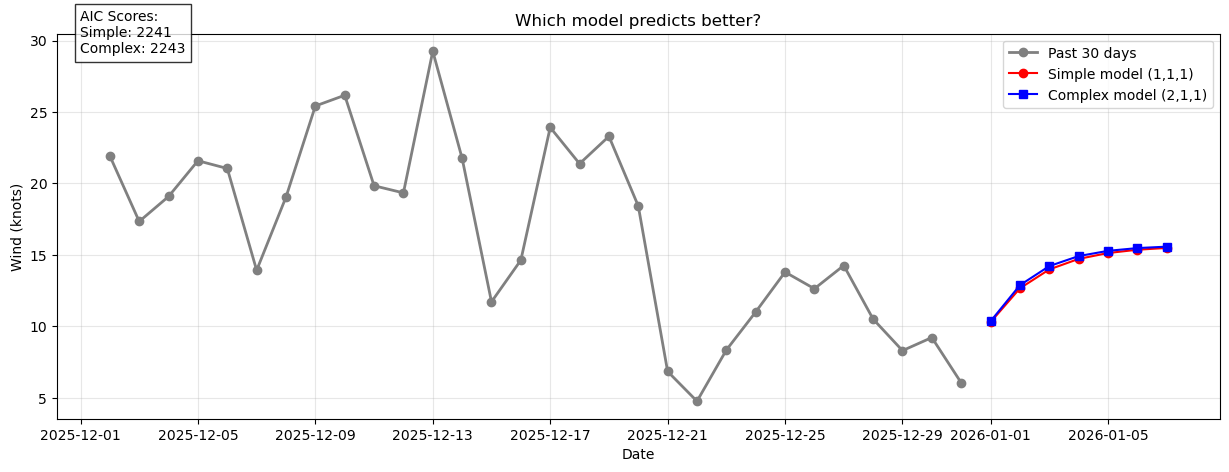

In [104]:
# testing 2 ARIMA models
m1 = ARIMA(daily_wind_2025, order=(1,1,1)).fit()
m2 = ARIMA(daily_wind_2025, order=(2,1,1)).fit()

# get forecasts
f1 = m1.forecast(steps=7)
f2 = m2.forecast(steps=7)

# plot
plt.figure(figsize=(15,5))
plt.plot(daily_wind_2025[-30:], 'k-', label='Past 30 days', linewidth=2, color='grey', marker='o')
plt.plot(f1.index, f1, 'ro-', label='Simple model (1,1,1)', markersize=6)
plt.plot(f2.index, f2, 'bs-', label='Complex model (2,1,1)', markersize=6)

plt.title('Which model predicts better?')
plt.xlabel('Date')
plt.ylabel('Wind (knots)')
plt.legend()
plt.grid(True, alpha=0.3)

# show AIC scores
plt.text(0.02, 0.95, f'AIC Scores:\nSimple: {m1.aic:.0f}\nComplex: {m2.aic:.0f}', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()


# https:/pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html
# https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html

# Code developed with AI assistance (DeepSeek) for parameter understanding. 
# code validation, and documentation verification against official library resources.
# Key references: Pandas time series, Statsmodels ARIMA, ACF/PACF documentation.  

--------  

**Result** :   

AIC difference: -1.8  
-   -1.81 is tiny improvement (needs >10 to be meaningful).  

Day 7 forecast difference: 0.09 knots  
-   That's negligible - needs to exceed 0.5% difference to be relevant.   

Practically identical forecasts *0.09 knots difference*, so choosing ARIMA(1,1,1) model as initial choice was correct.  

--------------

### 5.3 Energy Production Estimation


Using the universal wind power formula: P = ½ × ρ × A × v³  

Where:  
• ρ = 1.225 kg/m³ (standard sea-level air density)  
• A = 452.4 m² (swept area of 24m diameter turbine, typical example)  
• v = wind speed in m/s  

This demonstrates the cubic relationship where doubling wind speed produces 8× more power (2³ = 8) as explained in [Wind Energy and Power Calculations](https://www.e-education.psu.edu/emsc297/node/649)  



In [105]:
# energy calculation using the universal wind power formula: P = ½ × ρ × A × v³  

rho = 1.225  # air density 
diameter = 24  # turbine diameter 
A = 3.14159 * (diameter/2)**2  # area

# average wind speed ; convert wind knots into  m/s
avg_wind = np.mean(wind_speeds) 
avg_wind_ms = avg_wind * 0.514444  # convert to m/s

# apply wind power formula and calculate wind power in watts
power = 0.5 * rho * A * (avg_wind_ms ** 3)  
# divide by 1000 to get the values in kW
power_kw = power / 1000

print("Energy Potential at Mace Head:")
print("-" * 40)

print(f"Average wind: {avg_wind:.1f} knots ({avg_wind_ms:.1f} m/s)")
print(f"Theoretical power: {power_kw:.0f} kW")
print(f"Annual energy: {power_kw * 24 * 365 / 1000:.0f} MWh")

Energy Potential at Mace Head:
----------------------------------------
Average wind: 14.4 knots (7.4 m/s)
Theoretical power: 112 kW
Annual energy: 985 MWh


In [106]:
# using macehead yearly averages:
annual_energy = 0
# yearly average wind speed
for year_wind in wind_speeds:  
    wind_ms = year_wind * 0.514444
    power_kW = (0.5 * rho * A * (wind_ms ** 3)) / 1000
    energy_MWh = power_kW * 8760 / 1000  # (convert to annual, 8760 hours per year = 24*365)
    annual_energy += energy_MWh

average_annual = annual_energy / len(wind_speeds)
print(f"Estimated average annual energy: {average_annual:.0f} MWh/year")


# This code was generated with assistance from AI, based on the prompt: "Examples of calculating theoretical wind power using turbines"
# while AI (deepseek chatgpt) was used to assist with code generation, the methodology, assumptions, and interpretation of results were independently and closely verified by myself. .

Estimated average annual energy: 995 MWh/year


------------------------
**Result interpretation**   

A 24 m diameter turbine, exposed to a steady 7.4 m/s wind, would theoretically generate ~985 MWh per year

------------------------------


## 6. Additional visualizations

## 6.1 Heatmap

In [107]:
# check what columns we actually have
print("Current columns in macehead_df:")
print(macehead_df.columns.tolist())
print(f"\nNumber of columns: {len(macehead_df.columns)}")

Current columns in macehead_df:
['wdsp', 'year', 'rolling_24_windspeed', 'month', 'season', 'Threshold']

Number of columns: 6


### 6.1.1 Reload data

In [108]:
# load original data with temp column
macehead_df = pd.read_csv(file_path, skiprows=17)
# ensure df has date as index
macehead_df['date'] = pd.to_datetime(macehead_df['date'])
macehead_df.set_index('date', inplace=True)# show
# keep only windspeed and temperature columns
macehead_df = macehead_df[['wdsp', 'temp']].copy()
# show
macehead_df

C:\Users\marou\AppData\Local\Temp\ipykernel_24740\4040040439.py:2: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  macehead_df = pd.read_csv(file_path, skiprows=17)
C:\Users\marou\AppData\Local\Temp\ipykernel_24740\4040040439.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  macehead_df['date'] = pd.to_datetime(macehead_df['date'])


,wdsp,temp
date,,
2003-08-13 01:00:00,,
2003-08-13 02:00:00,,
2003-08-13 03:00:00,,
2003-08-13 04:00:00,,
2003-08-13 05:00:00,,
...,...,...
2025-12-31 20:00:00,5,4.2
2025-12-31 21:00:00,4,4.0
2025-12-31 22:00:00,3,4.7


In [109]:
# create Heatmap df with Years and Months
heatmap_df = macehead_df[['wdsp', 'temp']].copy()
heatmap_df['year'] = heatmap_df.index.year
heatmap_df['month'] = heatmap_df.index.month
# show
heatmap_df.columns.tolist()

['wdsp', 'temp', 'year', 'month']

### 6.1.2 Wind speed Heatmap (2003-2025)

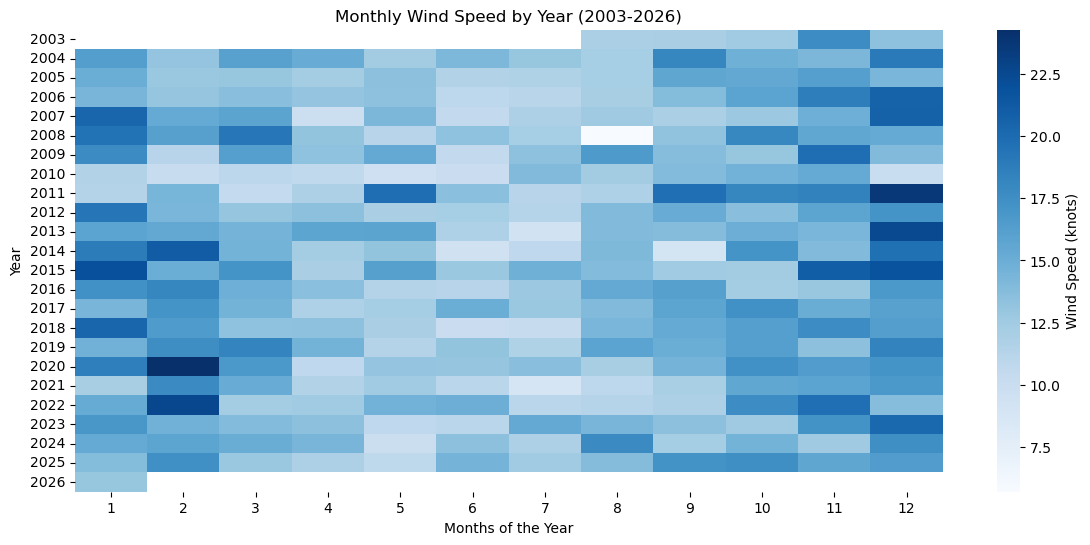

In [110]:
# wind speed data for heatmap
heatmap_wind_df = pd.DataFrame({'wdsp': m_mean_windspeed})
heatmap_wind_df['year'] = heatmap_wind_df.index.year
heatmap_wind_df['month'] = heatmap_wind_df.index.month

# create pivot table: years as rows and months as columns using windspeed values
wind_pivot = heatmap_wind_df.pivot_table(values='wdsp', index='year',columns='month',   aggfunc='mean')

# plot blue heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(wind_pivot, cmap='Blues',cbar_kws={'label': 'Wind Speed (knots)'})

plt.title('Monthly Wind Speed by Year (2003-2026)')
plt.xlabel('Months of the Year')
plt.ylabel('Year')
plt.show()

# https://stackoverflow.com/questions/67843385/building-heatmap-with-two-separate-series-having-year-and-month-information

-------------------------

The wind speed heatmap shows strong winter patterns with declining trend: The darkest blue regions consistently appear in winter months (December-January), confirming Mace Head's strongest winds occur annually during winter, howver recent years show slightly lighter blues suggesting a gradual decrease in peak winter wind intensities.  


----------------------------

### 6.1.3 Clean & prepare temperature data

In [111]:
# check temperature Dtype first, it shows as object.  
macehead_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 196248 entries, 2003-08-13 01:00:00 to 2026-01-01 00:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   wdsp    196248 non-null  object
 1   temp    196248 non-null  object
dtypes: object(2)
memory usage: 4.5+ MB


In [112]:
# replace empty strings with NaN first. We previously checked the original dataset, where some values were missing and replaced by ' ' 
macehead_df['temp'] = macehead_df['temp'].replace(' ', np.nan)
macehead_df['temp'] = macehead_df['temp'].replace('', np.nan)

# convert to float. change temperature Dtype into float instead of object
macehead_df['temp'] = pd.to_numeric(macehead_df['temp'], errors='coerce')

# resample hourly temperature to monthly mean temperature. Each row now represents a month with its average temp 
m_mean_temperature = macehead_df['temp'].resample("ME").mean()

### 6.1.4 Temperature Heatmap (2003-2025)

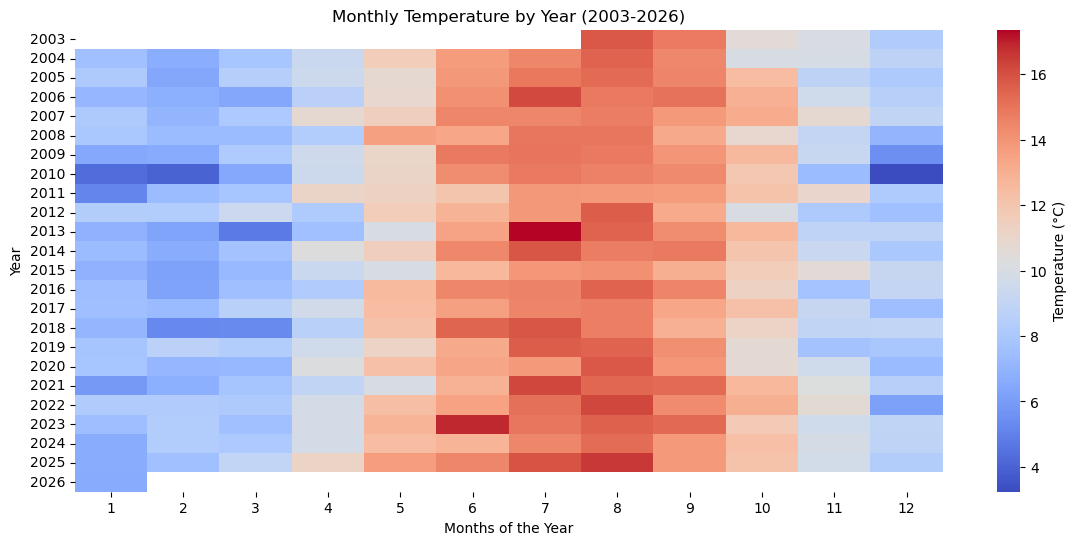

In [113]:
# temperature dataframe for heatmap
heatmap_temp_df = pd.DataFrame({'temp': m_mean_temperature})
heatmap_temp_df['year'] = heatmap_temp_df.index.year
heatmap_temp_df['month'] = heatmap_temp_df.index.month

# create pivot table: years as rows and months as columns with temperature values. 
temp_pivot = heatmap_temp_df.pivot_table(values='temp',index='year',columns='month',aggfunc='mean')

# plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(temp_pivot, cmap='coolwarm', cbar_kws={'label': 'Temperature (°C)'})

plt.title('Monthly Temperature by Year (2003-2026)')
plt.xlabel('Months of the Year')
plt.ylabel('Year')
plt.show()


# https://stackoverflow.com/questions/67843385/building-heatmap-with-two-separate-series-having-year-and-month-information

----------------------------------

The color gradient of the temperature Heatmap shows progressively warmer temperatures in recent years (2020 to 2025), particularly visible in winter months where blues are shifting toward warmer hues, indicating a clear warming trend over the two-decade period.  


--------------------------------


### 6.2 Yearly Wind speed (Bars) vs Temperature (Line) - 2003 to 2025

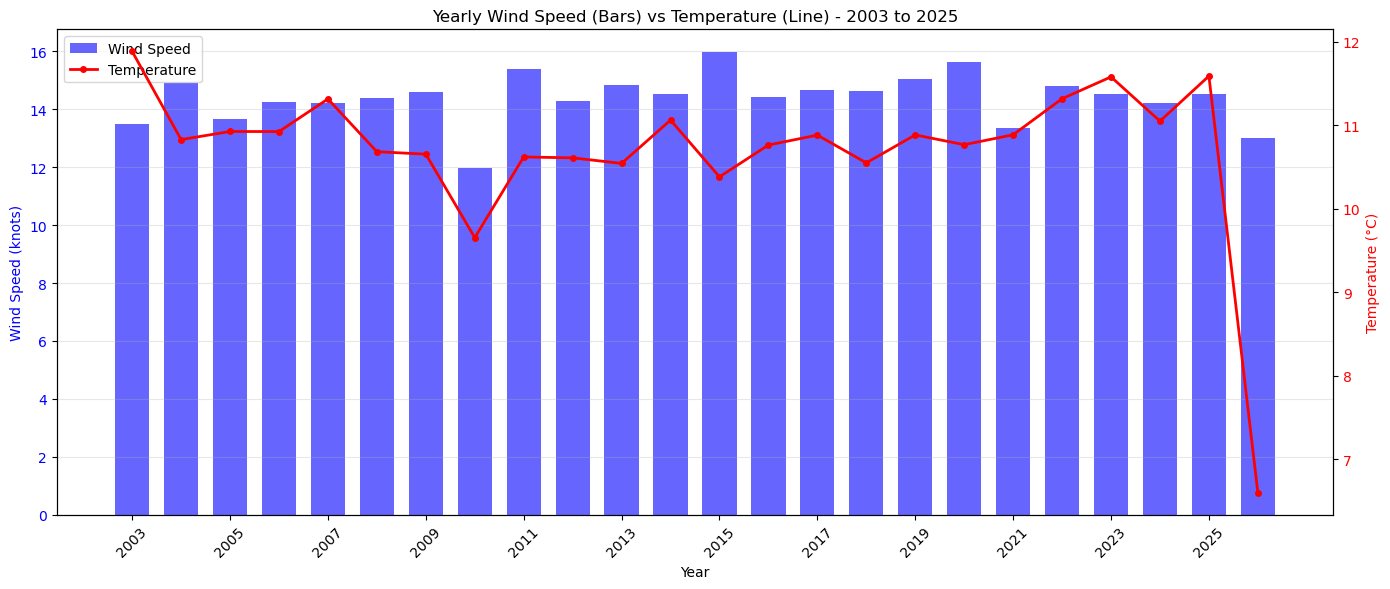

In [114]:
# recall yearly averages we previously calculated
yearly_wind = m_mean_windspeed.groupby(m_mean_windspeed.index.year).mean()
yearly_temp = m_mean_temperature.groupby(m_mean_temperature.index.year).mean()

# combine data into one data frame
combined_yearly = pd.DataFrame({'wind': yearly_wind,'temp': yearly_temp}).dropna()

# create figure
fig, ax1 = plt.subplots(figsize=(14, 6))

# bar plot of wind speed
bars = ax1.bar(combined_yearly.index, combined_yearly['wind'], color='blue', alpha=0.6, width=0.7, label='Wind Speed')

ax1.set_xlabel('Year')
ax1.set_ylabel('Wind Speed (knots)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(combined_yearly.index[::2])  # Show every other year
ax1.set_xticklabels(combined_yearly.index[::2], rotation=45)

# second y-axis for temperature, this creates a new Axes with an invisible x-axis and an independent y-axis positioned
ax2 = ax1.twinx()
line = ax2.plot(combined_yearly.index, combined_yearly['temp'], 'r-o', linewidth=2, markersize=4, label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# add title and grid
plt.title('Yearly Wind Speed (Bars) vs Temperature (Line) - 2003 to 2025')
ax1.grid(True, alpha=0.3, axis='y')

# combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

plt.tight_layout()
plt.show()


# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
# https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.twinx.html

-----------------------------------------

Windy years at Mace Head are usually colder years, as stronger winds often arrive with cold North Atlantic air masses and winter storm systems.  
The pattern is clear but not perfect, while most years follow this rule, some like 2011 to 2012 show both wind and temperature dropping together.  

---------------------------------------

### End